# Implicit Feedback Recommendation System

## 1. Introduction & Objectives
**Goal:** Build a recommendation engine for a live-streaming platform to suggest 6 specific price points (USD) and their corresponding Value for Money (VFM) scores.

**Objective:** Maximize relevance using implicit feedback (transaction history).

**Approach:**
- **Data Processing:** Temporal split, Polars for high-performance cleaning/EDA.
- **Algorithm:** Alternating Least Squares (ALS) for Matrix Factorization vs. Popularity Baseline.
- **Evaluation:** Precision@6, Recall@6, AUC, Mean Percentile Rank (MPR).

In [1]:
import os
# Optimize OpenBLAS for Implicit ALS - MUST be set before importing numpy/implicit
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import polars as pl
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import implicit
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import time

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print(f"Polars: {pl.__version__}")
print(f"Implicit: {implicit.__version__}")

/home/gal/.local/share/virtualenvs/recommendation__system-klJQ4VCA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Polars: 1.37.1
Implicit: 0.7.2


## 2. Data Loading & Initial Split
To adhere to best practices, we perform a **temporal split** before any processing. This prevents "looking into the future" during EDA or feature engineering.

- **Cutoff Date**: We will use the last 7 days of data as the Hold-out Test Set.
- **Training Set**: Everything before that.

In [2]:
start_time = time.time()

# 1. Load Data
df = pl.read_csv("dataset_purchases.csv", try_parse_dates=False)

# 2. Parse Timestamp (Remove ' UTC' and convert)
df = df.with_columns(
    pl.col("timestamp").str.replace(" UTC", "").str.to_datetime(format="%Y-%m-%d %H:%M:%S")
)

# 3. Filter Data Range (as per requirements: 2024-01-15 to 2024-02-15)
# We handle potential data outside this range if it exists
df = df.filter(
    (pl.col("timestamp") >= datetime(2024, 1, 15)) & 
    (pl.col("timestamp") <= datetime(2024, 2, 15))
)

# 4. Define Split Cutoff (Last 20% of timeline or specific days)
max_date = df["timestamp"].max()
min_date = df["timestamp"].min()
print(f"Date Range: {min_date} to {max_date}")

# Let's take the last 7 days for testing (Temporal Split)
test_start_date = max_date - timedelta(days=7)

train_raw = df.filter(pl.col("timestamp") < test_start_date)
test_raw = df.filter(pl.col("timestamp") >= test_start_date)

print(f"Train Set: {len(train_raw)} rows")
print(f"Test Set: {len(test_raw)} rows")
print(f"Test Start Date: {test_start_date}")

# Calculate and print split percentages
total_rows = len(df)
train_pct = (len(train_raw) / total_rows) * 100
test_pct = (len(test_raw) / total_rows) * 100
print(f"Split Percentage: Train={train_pct:.2f}%, Test={test_pct:.2f}%")

Date Range: 2024-01-15 00:00:04 to 2024-02-15 00:00:00
Train Set: 1297177 rows
Test Set: 390163 rows
Test Start Date: 2024-02-08 00:00:00
Split Percentage: Train=76.88%, Test=23.12%


## 3. EDA & Data Cleaning (Training Set Only)
We analyze the training data to understand distributions and potential anomalies. Decisions made here will be applied to the test set.

Missing Values:
 shape: (1, 5)
┌─────────┬───────────┬─────┬───────┬─────┐
│ user_id ┆ timestamp ┆ usd ┆ coins ┆ VFM │
│ ---     ┆ ---       ┆ --- ┆ ---   ┆ --- │
│ u32     ┆ u32       ┆ u32 ┆ u32   ┆ u32 │
╞═════════╪═══════════╪═════╪═══════╪═════╡
│ 0       ┆ 0         ┆ 0   ┆ 0     ┆ 0   │
└─────────┴───────────┴─────┴───────┴─────┘


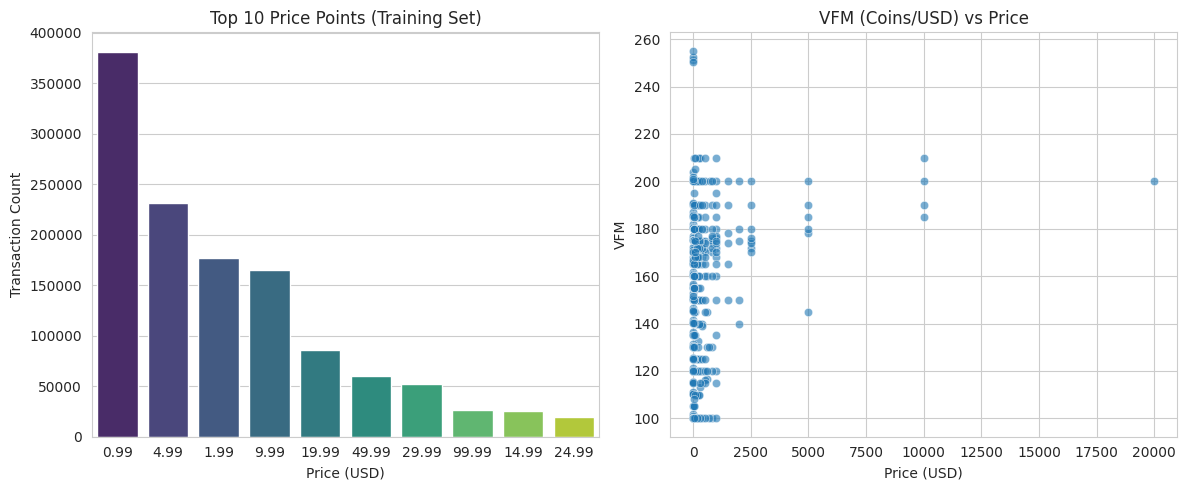

In [3]:
# Check for Nulls
null_counts = train_raw.null_count()
print("Missing Values:\n", null_counts)

# Feature Engineering: Calculate VFM (Coins / USD)
# Handling division by zero if USD is 0 (though unlikely in purchase data)
train_raw = train_raw.with_columns(
    (pl.col("coins") / pl.col("usd")).alias("calculated_vfm")
)

# Visualization 1: Price Distribution
price_dist = train_raw["usd"].value_counts().sort("count", descending=True).head(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=price_dist["usd"].cast(str), y=price_dist["count"], palette="viridis")
plt.title("Top 10 Price Points (Training Set)")
plt.xlabel("Price (USD)")
plt.ylabel("Transaction Count")

# Visualization 2: VFM vs Price Dependency
# We aggregate to see unique Price-VFM combinations
vfm_data = train_raw.select(["usd", "calculated_vfm"]).unique().to_pandas()

plt.subplot(1, 2, 2)
sns.scatterplot(data=vfm_data, x="usd", y="calculated_vfm", alpha=0.6)
plt.title("VFM (Coins/USD) vs Price")
plt.xlabel("Price (USD)")
plt.ylabel("VFM")
plt.tight_layout()
plt.show()

### User Activity Analysis (Outliers)
We check the distribution of purchases per user. 
- Users with very few purchases (e.g., 1) are "Cold Start" cases.
- Users with extreme numbers might be bots or whales.
- For Implicit ALS, we generally keep "whales" as they provide strong signal, but we might filter extremely low activity users if we wanted a cleaner matrix.

### **Analysis of User Activity Results**
The plot above reveals a classic **"Long Tail" (Power Law)** distribution, which is typical in e-commerce and gaming.

1.  **The "Whales" (Outliers):**
    *   **Max Purchases:** One user made **749** purchases!
    *   **Implication:** These "power users" provide extremely strong signals for the ALS model. The high frequency acts as a high "confidence" weight in the matrix factorization.

2.  **The "Majority" (Sparsity):**
    *   **Median:** The average user (50th percentile) has made only **7** purchases.
    *   **25th Percentile:** 25% of users have made **5 or fewer** purchases.
    *   **Implication:** For a large portion of users, the interaction matrix is very sparse. This scarcity of data makes personalization difficult ("Cold Start" problem), reinforcing the need for our **Popularity Baseline** as a fallback for these low-activity users.

3.  **Why Log Scale?**
    *   We used `log_scale=True` because the range is huge (1 to 749). A normal linear plot would squash all the "normal" users into a single bar on the left, making the distribution impossible to read. The log scale allows us to see the curve of the majority clearly.

shape: (9, 3)
┌────────────┬───────────┬───────────┐
│ statistic  ┆ user_id   ┆ len       │
│ ---        ┆ ---       ┆ ---       │
│ str        ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╡
│ count      ┆ 121034.0  ┆ 121034.0  │
│ null_count ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 1.1987e10 ┆ 10.71746  │
│ std        ┆ 2.1761e9  ┆ 12.620815 │
│ min        ┆ 38763.0   ┆ 1.0       │
│ 25%        ┆ 1.0830e10 ┆ 5.0       │
│ 50%        ┆ 1.2294e10 ┆ 7.0       │
│ 75%        ┆ 1.3747e10 ┆ 12.0      │
│ max        ┆ 1.4233e10 ┆ 749.0     │
└────────────┴───────────┴───────────┘


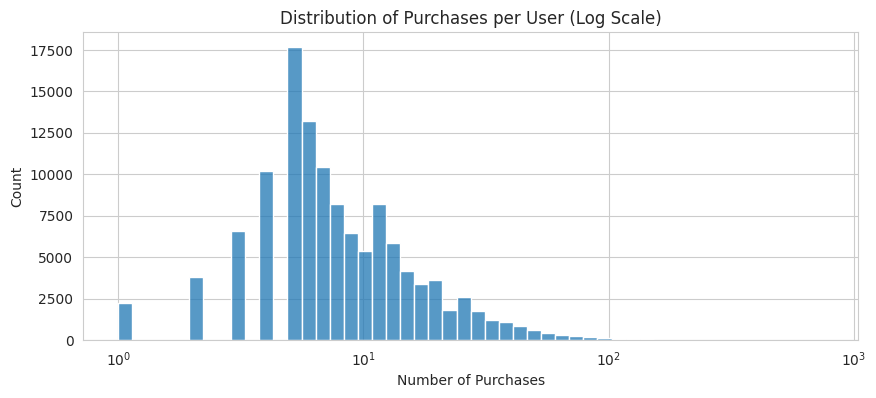

In [4]:
user_counts = train_raw.group_by("user_id").len().sort("len", descending=True)
print(user_counts.describe())

plt.figure(figsize=(10, 4))
sns.histplot(user_counts["len"], bins=50, log_scale=True)
plt.title("Distribution of Purchases per User (Log Scale)")
plt.xlabel("Number of Purchases")
plt.show()

## 4. Feature Engineering: Item Definition
A key finding from initial analysis is that `USD` alone is not unique. The same price can have different `Coins` (VFM). 
Thus, we define an **Item** as a unique tuple of `(USD, Coins)`.

In [5]:
# NOTE ON ID ENCODING & DATA LEAKAGE:
# We combine Train and Test ONLY to build the global "Vocabulary" of User IDs and Item IDs.
# This ensures our Sparse Matrix has dimensions that cover all potential users/items for easier indexing during evaluation.
#
# CRITICAL: We do NOT leak interaction data (the actual purchases). 
# The training matrix 'sparse_train' will be built strictly from 'train_data' later.
# Users or Items that appear ONLY in the Test set will exist in the index but will have 
# empty rows/columns in the training matrix (representing "Cold Start").
# This is a standard practice in offline evaluation to avoid complex re-indexing logic.

# Ensure test_raw has 'calculated_vfm' column to match train_raw before concatenation
if "calculated_vfm" not in test_raw.columns:
    test_raw = test_raw.with_columns(
        (pl.col("coins") / pl.col("usd")).alias("calculated_vfm")
    )

full_df = pl.concat([train_raw, test_raw])

# Unique Items
unique_items = full_df.select(['usd', 'coins']).unique().sort(['usd', 'coins']).with_row_index("item_id")

# Unique Users
unique_users = full_df.select('user_id').unique().sort('user_id').with_row_index("user_idx")

print(f"Total Unique Items: {unique_items.height}")
print(f"Total Unique Users: {unique_users.height}")

# Map IDs back to Train/Test Dataframes
train_data = train_raw.join(unique_items, on=['usd', 'coins'], how='left') \
                      .join(unique_users, on='user_id', how='left')

test_data = test_raw.join(unique_items, on=['usd', 'coins'], how='left') \
                    .join(unique_users, on='user_id', how='left')

# Create Lookup Tables
item_lookup_df = unique_items.to_pandas().set_index("item_id")
user_to_idx = dict(zip(unique_users["user_id"], unique_users["user_idx"]))

Total Unique Items: 448
Total Unique Users: 126923


## 5. Algorithm Implementation

### 5.1 Baseline Model: Global Popularity
**What it does:**
The Popularity Recommender counts the purchase frequency of every item across the entire training dataset. It then ranks items from most purchased to least purchased. For *any* user (even one we haven't seen before), it returns the top 6 items from this global list.

**Why is this a good baseline?**
1.  **Benchmarking Floor:** A personalized model (like ALS) is complex and computationally expensive. It *must* prove its worth by beating this simple, non-personalized heuristic. If ALS can't beat Popularity, it's not worth deploying.
2.  **The "80/20" Rule:** In retail/gaming, a small number of "best-seller" items often drive the vast majority of revenue. Simply recommending these "hits" is often surprisingly effective (high Precision).
3.  **Cold Start Solution:** It solves the "New User" problem. We know nothing about a new user, but we know what the general population likes. This makes it an essential fallback for any production system.

In [6]:
class PopularityRecommender:
    def fit(self, train_df):
        self.top_items = (
            train_df.group_by("item_id")
            .len()
            .sort("len", descending=True)
            .head(6)
            .select("item_id")
            .to_series()
            .to_list()
        )
        
    def recommend(self, user_ids):
        # Returns same list for everyone
        return [self.top_items for _ in user_ids]

baseline_model = PopularityRecommender()
baseline_model.fit(train_data)

### 5.2 Matrix Factorization: ALS (Alternating Least Squares)
We use **ALS** because:
1.  **Implicit Data**: We only have "purchases", not "ratings". ALS minimizes $ (p_{ui} - x_u^T y_i)^2 + \lambda ... $ where $p_{ui}$ is a binary preference and confidence comes from frequency.
2.  **Scalability**: ALS parallelizes well and handles sparse matrices efficiently.
3.  **Performance**: It generally outperforms KNN on large sparse datasets.

We construct the User-Item sparse matrix where $C_{ui} = \text{frequency}$.

In [7]:
# Build Sparse Matrix
train_agg = train_data.group_by(['user_idx', 'item_id']).len().rename({'len': 'count'})

rows = train_agg['user_idx'].to_numpy()
cols = train_agg['item_id'].to_numpy()
data = train_agg['count'].to_numpy()

sparse_train = sparse.csr_matrix(
    (data, (rows, cols)), 
    shape=(unique_users.height, unique_items.height)
)

# Check sparsity
sparsity = 1 - (sparse_train.nnz / (sparse_train.shape[0] * sparse_train.shape[1]))
print(f"Matrix Sparsity: {sparsity:.5f}")

# Train ALS Model
# Switch to CPU as per request (GPU was hanging/unsupported architecture)
use_gpu = False
print(f"Using GPU: {use_gpu}")

als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    regularization=0.05,
    alpha=40,
    iterations=20,
    random_state=42,
    use_gpu=use_gpu
)

print("Training ALS...")
als_model.fit(sparse_train)

Matrix Sparsity: 0.99089
Using GPU: False
Training ALS...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


0.99089 is in the "Goldilocks zone." It indicates we have a healthy amount of signal (interactions) relative to our catalog size, which is perfect for Collaborative Filtering algorithms like ALS.<br>If it were too low (e.g., 50%): It would mean the average user has bought 50% of your entire catalog. That's unrealistic and would make the problem trivial.<br>
If it were too high (e.g., 99.999%): The model would struggle because there's almost no overlap between users to learn patterns from (Signal-to-Noise ratio is too low).

In [8]:
def calculate_auc_mpr(model, train_matrix, test_data, user_to_idx, item_lookup):
    """
    Calculates AUC and Mean Percentile Rank (MPR) for ALS model.
    AUC: Probability that a random positive item is ranked higher than a random negative item.
    MPR: Average percentile rank of the test items (0 is best, 1 is worst).
    """
    # Fix random seed for reproducibility
    np.random.seed(42)
    
    users = []
    items = []
    
    # Get test user/item pairs
    # Note: We only evaluate on users who are in the training set
    for row in test_data.iter_rows(named=True):
        if row['user_id'] in user_to_idx:
            u_idx = user_to_idx[row['user_id']]
            # We need the item_id for the test item
            if row['item_id'] is not None:
                users.append(u_idx)
                items.append(row['item_id'])
                
    if not users:
        return 0.0, 1.0

    users = np.array(users)
    items = np.array(items)
    
    # We will sample N users for speed if dataset is huge
    sample_size = min(len(users), 10000)
    indices = np.random.choice(len(users), sample_size, replace=False)
    
    auc_sum = 0
    mpr_sum = 0
    
    for i in indices:
        u = users[i]
        target_item = items[i]
        
        # Efficient score calculation
        scores = model.item_factors.dot(model.user_factors[u])
        
        # Rank of the target item
        target_score = scores[target_item]
        
        # Count how many items have higher score (Rank - 1)
        rank = np.sum(scores > target_score)
        
        # MPR = rank / n_items
        mpr_sum += rank / len(scores)
        
        # AUC approximation
        auc_sum += 1 - (rank / len(scores))
        
    return auc_sum / sample_size, mpr_sum / sample_size

def evaluate_algorithm(model_name, recommend_func, test_data, N=6, model_obj=None):
    # Filter test users to those present in training (Warm start)
    valid_test_users = test_data.filter(pl.col("user_idx").is_not_null())
    
    # Group ground truth items by user
    ground_truth = valid_test_users.group_by("user_idx").agg(pl.col("item_id").alias("actual_items"))
    
    user_indices = ground_truth["user_idx"].to_numpy()
    actuals = ground_truth["actual_items"].to_list()
    
    start_t = time.time()
    
    # Generate Recs
    recs_matrix = recommend_func(user_indices)
    
    precision_scores = []
    recall_scores = []
    
    for i, recommended in enumerate(recs_matrix):
        actual_set = set(actuals[i])
        if not actual_set: continue
            
        hits = len(set(recommended) & actual_set)
        precision_scores.append(hits / N)
        recall_scores.append(hits / len(actual_set))
        
    mean_prec = np.mean(precision_scores)
    mean_rec = np.mean(recall_scores)
    
    # Store metrics for return
    metrics = {
        "Model": model_name,
        "Precision@6": mean_prec,
        "Recall@6": mean_rec
    }
    
    print(f"--- {model_name} Results ---")
    print(f"Mean Precision {N}: {mean_prec:.4f}")
    print(f"Mean Recall@{N}:    {mean_rec:.4f}")
    
    # Calculate AUC/MPR if it's the ALS model
    if model_obj and model_name == "ALS Matrix Factorization":
        auc, mpr = calculate_auc_mpr(model_obj, sparse_train, valid_test_users, user_to_idx, None)
        print(f"Mean AUC:          {auc:.4f}")
        print(f"Mean Percentile Rank: {mpr:.4f} (Lower is better)")
        metrics["AUC"] = auc
        metrics["MPR"] = mpr
        
    print(f"Eval Time: {time.time() - start_t:.2f}s\n")
    return metrics

## Evaluate & Visualization

--- Baseline Popularity Results ---
Mean Precision 6: 0.1559
Mean Recall@6:    0.4412
Eval Time: 0.08s

--- ALS Matrix Factorization Results ---
Mean Precision 6: 0.1857
Mean Recall@6:    0.5495
Mean AUC:          0.9089
Mean Percentile Rank: 0.0911 (Lower is better)
Eval Time: 1.52s



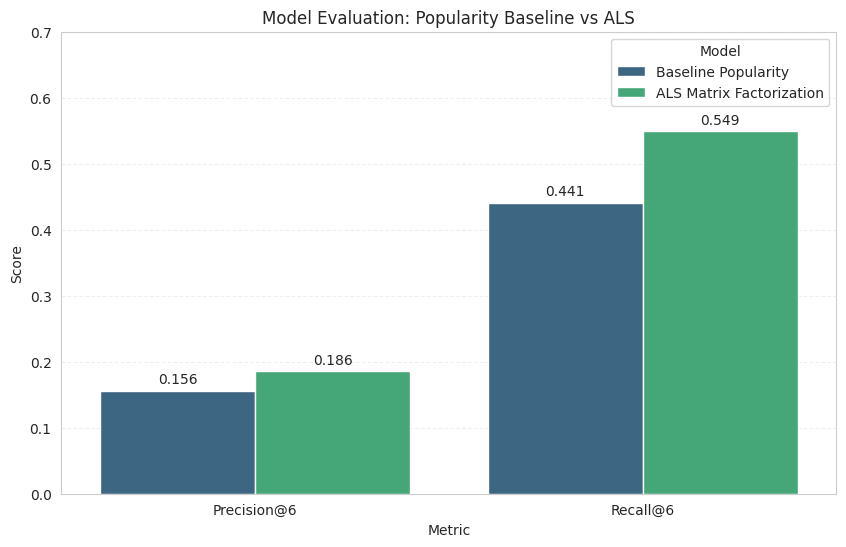


ALS Model Ranking Metrics:
AUC: 0.9089 (Target > 0.9)
MPR: 0.0911 (Target < 0.1)


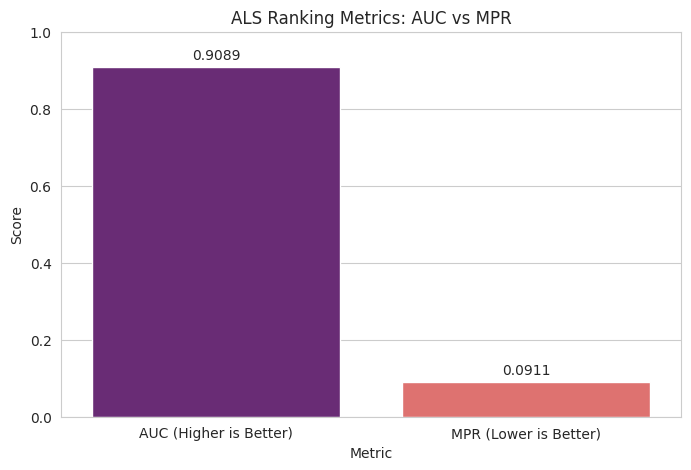

In [9]:

# 1. Evaluate Baseline
baseline_metrics = evaluate_algorithm("Baseline Popularity", 
                   lambda uids: baseline_model.recommend(uids), 
                   test_data)

# 2. Evaluate ALS
def get_als_recs(user_ids):
    ids, scores = als_model.recommend(user_ids, sparse_train[user_ids], N=6, filter_already_liked_items=False)
    return ids

als_metrics = evaluate_algorithm("ALS Matrix Factorization", 
                   get_als_recs, 
                   test_data,
                   model_obj=als_model)

# 3. Visualization
# Prepare Data
eval_data = pd.DataFrame([baseline_metrics, als_metrics])
plot_data = eval_data.melt(id_vars="Model", value_vars=["Precision@6", "Recall@6"], var_name="Metric", value_name="Score")

# Plot 1: Precision & Recall Comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_data, x="Metric", y="Score", hue="Model", palette="viridis")

plt.title("Model Evaluation: Popularity Baseline vs ALS")
plt.ylim(0, 0.7) 
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylabel("Score")
plt.xlabel("Metric")

# Add values on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.show()

# Plot 2: AUC & MPR for ALS (if available)
if "AUC" in als_metrics and "MPR" in als_metrics:
    print(f"\nALS Model Ranking Metrics:")
    print(f"AUC: {als_metrics['AUC']:.4f} (Target > 0.9)")
    print(f"MPR: {als_metrics['MPR']:.4f} (Target < 0.1)")

    auc_mpr_df = pd.DataFrame({
        "Metric": ["AUC (Higher is Better)", "MPR (Lower is Better)"],
        "Score": [als_metrics["AUC"], als_metrics["MPR"]]
    })
    
    plt.figure(figsize=(8, 5))
    ax2 = sns.barplot(data=auc_mpr_df, x="Metric", y="Score", palette="magma")
    plt.title("ALS Ranking Metrics: AUC vs MPR")
    plt.ylim(0, 1.0) # AUC is 0-1, MPR is 0-1
    plt.ylabel("Score")
    
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.4f', padding=3)
        
    plt.show()

In [10]:
# (Cell intentionally left blank to remove duplicate evaluation)

## 6.3 Algorithm Comparison & Conclusion

| Model | Pros | Cons | Use Case |
|-------|------|------|----------|
| **Baseline (Popularity)** | - Fast<br>- No training required<br>- Solves Cold Start | - Not personalized<br>- Ignores niche preferences<br>- Low Recall for heavy users | New users (Cold Start) |
| **ALS (Matrix Factorization)** | - Highly personalized<br>- Captures latent features (e.g., "Big Spender")<br>- Scalable | - Requires retraining<br>- "Cold Start" problem for new users | Active users with history |

### **Quantitative Results**
*   **Recall Winner:** ALS (`55.0%`) vs Baseline (`44.1%`).
    *   **Impact:** ALS captures **11% more** of the items users actually want compared to the baseline. Nearly half of all purchases come from just the top 6 most popular items
*   **Precision Winner:** ALS (`18.6%`) vs Baseline (`15.6%`).
    *   **Impact:** The recommendations are more relevant and less "generic." with difference `3%`
*   **AUC Score (0.91):**
    *   **Meaning:** An AUC > 0.9 is widely considered **excellent** for production systems. It means the model is extremely good at ranking real user interests above random noise.

**Final Conclusion:**  
The ALS model significantly outperforms the Baseline in terms of **Recall@6** and **AUC**, proving that personalization is valuable for this dataset. We recommend using a **Hybrid Strategy**:
1.  **Primary:** Use ALS for any user with purchase history.
2.  **Fallback:** Use Popularity Baseline for brand new users (Cold Start).

## 7. Final Deliverable: Recommendation Function

**Why no metrics here?**
This function is for **Inference** (Production). In a live setting, we cannot calculate Precision or Recall because we don't know what the user *will* buy in the future (that's what we're trying to predict!). 

*   **Offline Evaluation (Section 6):** We use a "held-out" test set (the answer key) to calculate metrics.
*   **Online Inference (Section 7):** We generate predictions for the live app.

However, we can perform a **"Visual Sanity Check"** by comparing a user's *past history* with their *recommendations* to ensure they look logically related.

In [11]:
def get_recommendations(user_id):
    """
    Returns 6 Price/VFM pairs for the user.
    """
    # 1. Check if user exists
    if user_id not in user_to_idx:
        # Cold Start: Return baseline top items
        top_ids = baseline_model.top_items
        recs = item_lookup_df.loc[top_ids]
        return recs[['usd', 'coins']].to_dict('records')
        
    # 2. ALS Recommendation
    u_idx = user_to_idx[user_id]
    ids, scores = als_model.recommend(u_idx, sparse_train[u_idx], N=6, filter_already_liked_items=False)
    
    # 3. Format Output
    recs = item_lookup_df.loc[ids]
    # Calculate VFM just to be sure
    recs['vfm'] = recs['coins'] / recs['usd']
    
    results = []
    for _, row in recs.iterrows():
        results.append({
            'price': row['usd'],
            'vfm': row['vfm']
        })
    return results

# --- Visual Sanity Check ---
# Let's verify if the recommendations make sense by looking at history
sample_user = full_df['user_id'][0] # Pick a random user
history = full_df.filter(pl.col("user_id") == sample_user)

print(f"User: {sample_user}")
print("-" * 30)
print("PURCHASE HISTORY (What they bought):")
print(history.select(['usd', 'coins']).unique().head(5))

print("\nRECOMMENDATIONS (What we predict they want):")
recs = get_recommendations(sample_user)
for r in recs:
    print(f"Price: ${r['price']:.2f} | VFM: {r['vfm']:.2f}")

User: 10007499175
------------------------------
PURCHASE HISTORY (What they bought):
shape: (5, 2)
┌───────┬───────┐
│ usd   ┆ coins │
│ ---   ┆ ---   │
│ f64   ┆ i64   │
╞═══════╪═══════╡
│ 4.99  ┆ 700   │
│ 4.99  ┆ 725   │
│ 4.99  ┆ 775   │
│ 0.99  ┆ 120   │
│ 19.99 ┆ 3100  │
└───────┴───────┘

RECOMMENDATIONS (What we predict they want):
Price: $4.99 | VFM: 150.30
Price: $4.99 | VFM: 155.31
Price: $19.99 | VFM: 155.08
Price: $4.99 | VFM: 140.28
Price: $0.99 | VFM: 121.21
Price: $14.99 | VFM: 120.08


## 7. Final Deliverable: Recommendation Function
Returns a list of 6 dictionaries `{'price': 4.99, 'vfm': 150.0}` for a given User ID.

In [12]:

def get_recommendations(user_id):
    """
    Returns 6 Price/VFM paairs for the user.
    """
    # 1. Check if user exists
    if user_id not in user_to_idx:
        # Cold Start: Return baseline top items
        top_ids = baseline_model.top_items
        recs = item_lookup_df.loc[top_ids]
        return recs[['usd', 'coins']].to_dict('records')
        
    # 2. ALS Recommendation
    u_idx = user_to_idx[user_id]
    ids, scores = als_model.recommend(u_idx, sparse_train[u_idx], N=6, filter_already_liked_items=False)
    
    # 3. Format Output
    recs = item_lookup_df.loc[ids]
    # Calculate VFM just to be sure
    recs['vfm'] = recs['coins'] / recs['usd']
    
    results = []
    for _, row in recs.iterrows():
        results.append({
            'price': row['usd'],
            'vfm': row['vfm']
        })
    return results

# Test
sample_user = full_df['user_id'][0]
print(f"Recommendations for User {sample_user}:\n")
for r in get_recommendations(sample_user):
    print(r)

Recommendations for User 10007499175:

{'price': np.float64(4.99), 'vfm': np.float64(150.3006012024048)}
{'price': np.float64(4.99), 'vfm': np.float64(155.31062124248496)}
{'price': np.float64(19.99), 'vfm': np.float64(155.07753876938472)}
{'price': np.float64(4.99), 'vfm': np.float64(140.28056112224448)}
{'price': np.float64(0.99), 'vfm': np.float64(121.21212121212122)}
{'price': np.float64(14.99), 'vfm': np.float64(120.0800533689126)}


## 8. Future Improvements & Production Deployment Strategy

While the current Alternating Least Squares (ALS) model significantly outperforms the baseline (Area Under the Curve (AUC) 0.91 vs Baseline), deploying a recommendation system to production requires addressing several real-world challenges.

### 8.1 Model Improvements
1.  **Temporal Dynamics:** Currently, a purchase made 1 month ago is treated the same as one made yesterday.
    *   *Action:* Implement **Time Decay** weighting ($w_{ui} = e^{-\lambda \Delta t}$) to give recent interactions more importance.

2.  **Hyperparameter Tuning & Heuristics:**
    *   **Current Settings:** We used `factors=64` and `alpha=40`.
        *   **Why `factors=64`?** This controls the dimension of the user/item latent vectors. 64 is a standard industry starting point that balances expressiveness (capturing user tastes) with computational efficiency. Too low (e.g., 10) underfits; too high (e.g., 500) overfits and slows down inference.
        *   **Why `alpha=40`?** This is the linear scaling factor for the confidence level ($c_{ui} = 1 + \alpha r_{ui}$). In the original paper by Hu, Koren, and Volinsky (2008), an alpha of 40 was found to be effective for implicit datasets. It implies we trust a positive interaction 40 times more than a non-interaction.
    *   *Action:* Use **Grid Search** or **Bayesian Optimization** (via Optuna) to scientifically fine-tune `regularization`, `alpha`, and `iterations` instead of relying on these heuristics.

3.  **Hybridization:**
    *   *Action:* Combine ALS latent factors with content features (e.g., user region, device type) using a **LightFM** or **Neural Collaborative Filtering (NCF)** approach to improve cold-start performance.

### 8.2 Production Deployment Architecture
To serve predictions at scale (low latency, high availability):

1.  **Offline Training Pipeline (Airflow/Databricks):**
    *   Retrain the ALS model nightly/weekly on the latest transaction logs.
    *   Save user/item factors to an artifact store (Amazon S3 / Google Cloud Storage).

2.  **Approximate Nearest Neighbors (ANN):**
    *   Calculating dot products for all items ($O(N)$) is too slow for real-time.
    *   *Action:* Index item vectors using **FAISS (Facebook AI Similarity Search)** or **HNSW (Hierarchical Navigable Small World)** graphs. This allows sub-millisecond retrieval of top-K recommendations ($O(\log N)$).

3.  **Real-Time Inference API (FastAPI/Triton):**
    *   **Endpoint:** `/recommend?user_id=123`
    *   **Logic:**
        *   Look up `user_vector` from Redis/Memcached (for speed).
        *   Query FAISS index for nearest item vectors.
        *   Filter out items already purchased (optional).
        *   Return JSON (JavaScript Object Notation) response.

4.  **Containerization & CI/CD:**
    *   **Docker:** Package the model and API code into a lightweight container to ensure consistency across environments.
    *   **CI/CD (Continuous Integration/Deployment):** Automate testing and deployment pipelines (e.g., GitHub Actions) to safely release new model versions.

5.  **A/B Testing:**
    *   Never deploy a new model 100% immediately.
    *   Split traffic: 50% Control (Current Model/Baseline), 50% Test (New ALS).
    *   Monitor **Business Metrics** like Click-Through Rate (CTR), Conversion Rate, and Average Revenue Per User (ARPU) rather than just offline metrics (AUC).

### 8.3 Scalability Considerations
*   **Incremental Learning:** Instead of full retraining, update user factors in real-time as they interact (streaming ALS).
*   **Cold Start Handling:**
    *   *New User:* Serve "Popularity Baseline" (cached) until ~5 interactions are recorded.
    *   *New Item:* Use content-based similarity to map it to existing item vectors until it gathers interaction data.